In [1]:
import numpy as np
import pandas as pd
from BERT import bert_embed_text
from tqdm import tqdm
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torch_functions as torch_fns
from torchinfo import summary
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
# Setup device agnostic code (Chooses NVIDIA or Metal backend if available, otherwise defaults to CPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
    
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    
else:
    device = torch.device("cpu")
device

device(type='mps')

In [3]:
# loading the articles to embed
articles = pd.read_csv("../data/clean/MicrosoftANDquantum_None.csv")
# remove rows with na as body
articles = articles.dropna(subset=['body'])

In [4]:
articles.head(3)

,engine,link,se_description,se_source,n3k_author,n3k_published,title,body
0,Yahoo,https://seekingalpha.com/article/4603046-micro...,Quantum computing is a disruptive technology t...,Seeking Alpha,['Aseity Research'],2023-05-11 11:03:43-04:00,Microsoft Stock: Leading The Quantum Computing...,Bartlomiej Wroblewski\n\nQuantum computing is ...
1,Yahoo,https://www.morningstar.com/news/pr-newswire/2...,Quantum Computing Inc. initiates commercializa...,Morningstar,[],2023-05-11 15:01:00-05:00,Quantum Computing Inc Announces First Quarter ...,Quantum Computing Inc. initiates commercializa...
2,Bing,https://phys.org/news/2023-05-google-quantum-a...,Our intuition tells us that it should be impos...,Phys.org,['Google Quantum Ai'],NaN,Google Quantum AI braids non-Abelian anyons fo...,This article has been reviewed according to Sc...


### Uncomment below cell when running notebook for the first time

In [5]:
#An alternative would be to try summarizing by paragraph (we shall do that soon)

# articles['body_embedding'] = None
# for i in tqdm(range(len(articles))):
#     try:
#         articles.at[i,'body_embedding'] = bert_embed_text(articles.at[i,'body']).tolist()
#     except:
#         articles.at[i,'body_embedding'] = []

# articles.to_parquet('../data/misc/quant_embed.gzip',compression='gzip', index=False)

In [6]:
bert_embed_text = pd.read_parquet('../data/misc/quant_embed.gzip')
sentence_embeddings_df = pd.DataFrame(bert_embed_text['body_embedding'].tolist(), index=bert_embed_text.index).dropna().values
sentence_embeddings = MinMaxScaler().fit_transform(np.array(sentence_embeddings_df))
data = torch.from_numpy(sentence_embeddings).type(torch.float32)

In [7]:
data.shape, data.dtype, data.max(), data.min()

(torch.Size([166, 768]), torch.float32, tensor(1.), tensor(0.))

In [8]:
# Setup hyperparameters
NUM_EPOCHS = 500
BATCH_SIZE = 16
INPUT_SHAPE = 768
HIDDEN_UNITS = list([256, 128, 64, 32, 2]) # For some reason fails when just doing [] kekw
OUTPUT_SHAPE = 768
LEARNING_RATE = 0.0002 #Default adam is 1e-3
DROPOUT = 0.2

In [9]:
# Setup DataLoaders
from os import cpu_count
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

In [10]:
next(iter(dataloader)).shape, len(dataloader)

(torch.Size([16, 768]), 11)

In [11]:
# Instantiate model
model = torch_fns.Autoencoder(INPUT_SHAPE, HIDDEN_UNITS, OUTPUT_SHAPE, DROPOUT)

In [12]:
# Print a summary using torchinfo
summary(model=model, 
        input_size=(BATCH_SIZE, INPUT_SHAPE),
        # col_names=["input_size"],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Autoencoder (Autoencoder)                [16, 768]            [16, 768]            --                   True
├─Sequential (encode)                    [16, 768]            [16, 32]             --                   True
│    └─Linear (0)                        [16, 768]            [16, 256]            196,864              True
│    └─Dropout (1)                       [16, 256]            [16, 256]            --                   --
│    └─Linear (2)                        [16, 256]            [16, 32]             8,224                True
├─Sequential (decode)                    [16, 32]             [16, 768]            --                   True
│    └─Linear (0)                        [16, 32]             [16, 256]            8,448                True
│    └─Dropout (1)                       [16, 256]            [16, 256]            --                   --
│    └─Linear (2) 

In [13]:
# Set loss and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Start training with help from torch_functions.py
results = torch_fns.train(
    model=model,
    dataloader=dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    device=device,
)


Epoch: 1 | loss: 0.2572
Epoch: 2 | loss: 0.1453
Epoch: 3 | loss: 0.0734
Epoch: 4 | loss: 0.0486
Epoch: 5 | loss: 0.0402
Epoch: 6 | loss: 0.0393
Epoch: 7 | loss: 0.0355
Epoch: 8 | loss: 0.0336
Epoch: 9 | loss: 0.0324
Epoch: 10 | loss: 0.0321
Epoch: 11 | loss: 0.0310
Epoch: 12 | loss: 0.0313
Epoch: 13 | loss: 0.0316
Epoch: 14 | loss: 0.0303
Epoch: 15 | loss: 0.0290
Epoch: 16 | loss: 0.0295
Epoch: 17 | loss: 0.0283
Epoch: 18 | loss: 0.0270
Epoch: 19 | loss: 0.0269
Epoch: 20 | loss: 0.0261
Epoch: 21 | loss: 0.0260
Epoch: 22 | loss: 0.0250
Epoch: 23 | loss: 0.0243
Epoch: 24 | loss: 0.0253
Epoch: 25 | loss: 0.0237
Epoch: 26 | loss: 0.0232
Epoch: 27 | loss: 0.0224
Epoch: 28 | loss: 0.0228
Epoch: 29 | loss: 0.0227
Epoch: 30 | loss: 0.0218
Epoch: 31 | loss: 0.0215
Epoch: 32 | loss: 0.0213
Epoch: 33 | loss: 0.0210
Epoch: 34 | loss: 0.0207
Epoch: 35 | loss: 0.0209
Epoch: 36 | loss: 0.0212
Epoch: 37 | loss: 0.0206
Epoch: 38 | loss: 0.0200
Epoch: 39 | loss: 0.0197
Epoch: 40 | loss: 0.0190
Epoch: 41

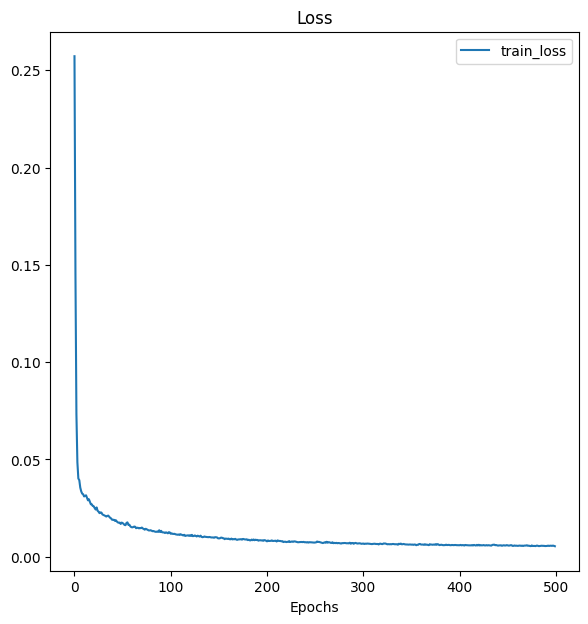

In [14]:
torch_fns.plot_loss_curves(results)

In [15]:
with torch.inference_mode():
    model = model.to(device)
    data = data.to(device)
    encoded = model.encode(data)
    decoded = model.decode(encoded)
    error = loss_fn(decoded, data).item()
    enc = encoded.cpu().numpy()
    dec = decoded.cpu().numpy()

print(f'Root mean squared error: {np.sqrt(error):.4f}')

Root mean squared error: 0.0750


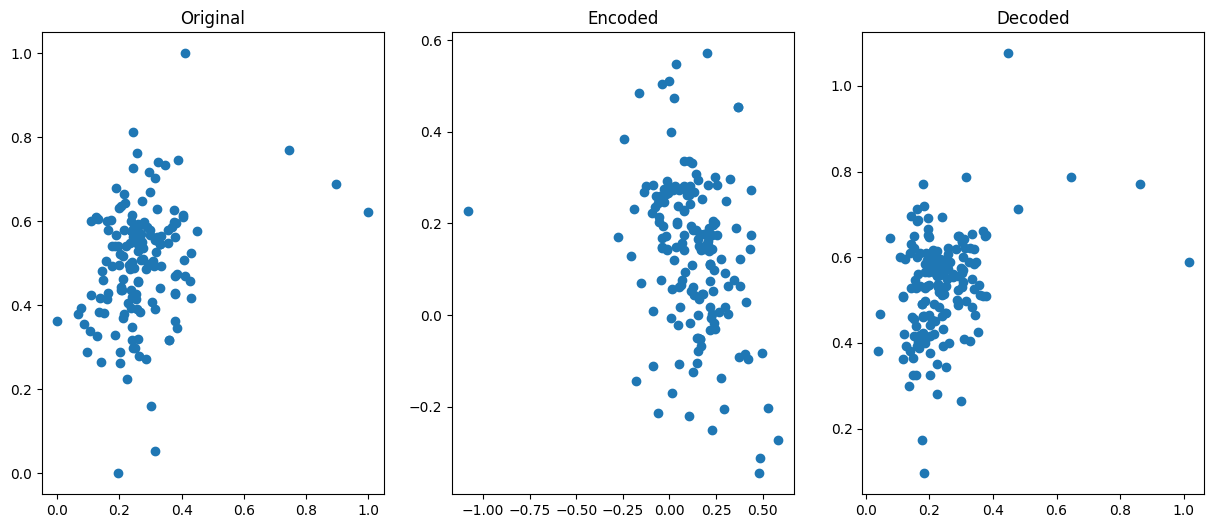

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))

ax1.scatter(sentence_embeddings[:,0], sentence_embeddings[:,1])
ax1.set_title('Original')

ax2.scatter(enc[:,0], enc[:,1])
ax2.set_title('Encoded')

ax3.scatter(dec[:,0], dec[:,1])
ax3.set_title('Decoded')

plt.show()

/Users/johnbergmann/.pyenv/versions/3.8.16/envs/RB_NLP/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


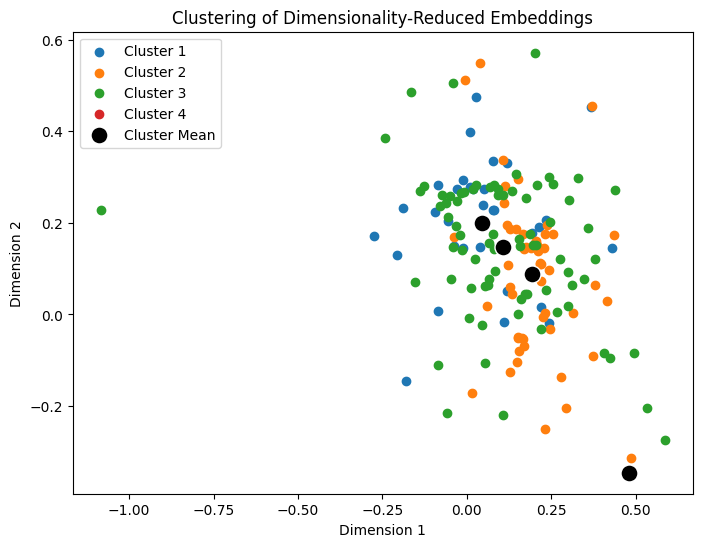

In [27]:
# Perform clustering
n_clusters = 4  # Number of clusters
kmeans = KMeans(n_clusters=n_clusters)
cluster_labels = kmeans.fit_predict(enc)

# Calculate cluster means
cluster_centers = kmeans.cluster_centers_

# Create scatter plot
plt.figure(figsize=(8, 6))
for cluster_label in range(n_clusters):
    cluster_points = enc[cluster_labels == cluster_label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_label + 1}')

# Add legend
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='o', s=150, c='black', edgecolors='white', label='Cluster Mean')
plt.legend()

# Show the plot
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Clustering of Dimensionality-Reduced Embeddings')
plt.show()
